# MLG382 
- ## Project 2 
- Group M

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from datetime import date, datetime, timedelta
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import warnings
import numpy as np
import seaborn as sns
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

warnings.simplefilter('ignore', category=Warning, lineno=0, append=False)

# Business Understanding

## Problem

A small to medium enterprise wants to improve their marketing strategy by tailoring it to different groups of customers according to their behaviour, hoping to increase sales. They want to know which customers they should offer incentitives, to encourage them to make more purchases and spend more money. They also want to know which customers are loyal and big spenders in order to offer them rewards for supporting the business.

## Approach

According to the business needs a customer segmentation based on behaviour is needed. A Regency Frequency Monetary (RFM) analysis is a good reflection of customer behaviour. Once a RFM analysis is done, customers can be segmented into groups by use of k-means clustering. Behaviour of these groups can be determined by looking at the mean of each group and a different marketing strategy can then be recommneded for a specific customer based on which group they fall under.


## Data

The business provides a data set containing the following information about their sales: InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID and Country. For a behavioural customer segmentation the geographical location is irrellevant. For the RFM data analysis we only need the InvoiceNo, Quantity, InvoiceDate, UnitPrice and Customer ID.


# Data Preparation

In [20]:
# import data
raw_df = pd.read_excel('..\data\\Online_Retail.xlsx')
raw_df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [21]:
# Understand data structure
print(raw_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
None


In [22]:
raw_df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [23]:
#Data Cleaning
# Drop 'Country' and 'InvoiceNo' columns
processed_df = raw_df.drop(['Country','Description'], axis=1)

# Remove rows with quantity less than or equal to zero
processed_df = processed_df[processed_df['Quantity'] >= 0]

# Remove rows with missing CustomerID
processed_df = processed_df.dropna(subset=['CustomerID'])

# Reset the index after removing rows
processed_df.reset_index(drop=True, inplace=True)

# Display the first few rows of the processed DataFrame
print(processed_df.head())

  InvoiceNo StockCode  Quantity         InvoiceDate  UnitPrice  CustomerID
0    536365    85123A         6 2010-12-01 08:26:00       2.55     17850.0
1    536365     71053         6 2010-12-01 08:26:00       3.39     17850.0
2    536365    84406B         8 2010-12-01 08:26:00       2.75     17850.0
3    536365    84029G         6 2010-12-01 08:26:00       3.39     17850.0
4    536365    84029E         6 2010-12-01 08:26:00       3.39     17850.0


In [24]:
#Data Processing
processed_df['Quantity'] = processed_df['Quantity'].astype(int)
processed_df['CustomerID'] = processed_df['CustomerID'].astype(str)
print(processed_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397924 entries, 0 to 397923
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397924 non-null  object        
 1   StockCode    397924 non-null  object        
 2   Quantity     397924 non-null  int32         
 3   InvoiceDate  397924 non-null  datetime64[ns]
 4   UnitPrice    397924 non-null  float64       
 5   CustomerID   397924 non-null  object        
dtypes: datetime64[ns](1), float64(1), int32(1), object(3)
memory usage: 16.7+ MB
None


In [25]:
processed_df['Amount'] = processed_df['Quantity']*processed_df['UnitPrice']
rfm_ds_n = processed_df.groupby('CustomerID')['Amount'].sum()
rfm_ds_n.reset_index()
rfm_ds_n.columns = ['CustomerID', 'Amount']
print(rfm_ds_n)

CustomerID
12346.0    77183.60
12347.0     4310.00
12348.0     1797.24
12349.0     1757.55
12350.0      334.40
             ...   
18280.0      180.60
18281.0       80.82
18282.0      178.05
18283.0     2094.88
18287.0     1837.28
Name: Amount, Length: 4339, dtype: float64


In [26]:
rfm_ds_f = processed_df.groupby('CustomerID')['InvoiceNo'].count()
rfm_ds_f = rfm_ds_f.reset_index()
rfm_ds_f.columns = ['CustomerID','Frequency']
print(rfm_ds_f)

     CustomerID  Frequency
0       12346.0          1
1       12347.0        182
2       12348.0         31
3       12349.0         73
4       12350.0         17
...         ...        ...
4334    18280.0         10
4335    18281.0          7
4336    18282.0         12
4337    18283.0        756
4338    18287.0         70

[4339 rows x 2 columns]


In [27]:
processed_df['InvoiceDate'] = pd.to_datetime(processed_df['InvoiceDate'],format='%m/%d/%Y %H:%M')
max_date = max(processed_df['InvoiceDate'])
processed_df['Diff'] = max_date - processed_df['InvoiceDate']
rfm_ds_p = processed_df.groupby('CustomerID')['Diff'].min()
rfm_ds_p = rfm_ds_p.reset_index()
rfm_ds_p.columns = ['CustomerID', 'Diff']
rfm_ds_p['Diff'] = rfm_ds_p['Diff'].dt.days
print(rfm_ds_p)

     CustomerID  Diff
0       12346.0   325
1       12347.0     1
2       12348.0    74
3       12349.0    18
4       12350.0   309
...         ...   ...
4334    18280.0   277
4335    18281.0   180
4336    18282.0     7
4337    18283.0     3
4338    18287.0    42

[4339 rows x 2 columns]


In [28]:
rfm_ds_final = pd.merge(rfm_ds_n, rfm_ds_f, on='CustomerID',how='inner')
rfm_ds_final = pd.merge(rfm_ds_final, rfm_ds_p, on='CustomerID', how='inner')
rfm_ds_final.columns = ['CustomerID', 'Amount', 'Frequency', 'Recency']
print(rfm_ds_final)

     CustomerID    Amount  Frequency  Recency
0       12346.0  77183.60          1      325
1       12347.0   4310.00        182        1
2       12348.0   1797.24         31       74
3       12349.0   1757.55         73       18
4       12350.0    334.40         17      309
...         ...       ...        ...      ...
4334    18280.0    180.60         10      277
4335    18281.0     80.82          7      180
4336    18282.0    178.05         12        7
4337    18283.0   2094.88        756        3
4338    18287.0   1837.28         70       42

[4339 rows x 4 columns]


In [29]:
#Outliers
Q1 = rfm_ds_final.Amount.quantile(0.25)
Q3 = rfm_ds_final.Amount.quantile(0.75)
IQR = Q3-Q1
rfm_ds_final = rfm_ds_final[(rfm_ds_final.Amount > Q1 - 1.5*IQR) & (rfm_ds_final.Amount < Q3 + 1.5*IQR)]

Q1 = rfm_ds_final.Recency.quantile(0.25)
Q3 = rfm_ds_final.Recency.quantile(0.75)
IQR = Q3-Q1
rfm_ds_final = rfm_ds_final[(rfm_ds_final.Recency > Q1 - 1.5*IQR) & (rfm_ds_final.Recency < Q3 + 1.5*IQR)]

Q1 = rfm_ds_final.Frequency.quantile(0.25)
Q3 = rfm_ds_final.Frequency.quantile(0.75)
IQR = Q3-Q1
rfm_ds_final = rfm_ds_final[(rfm_ds_final.Frequency > Q1 - 1.5*IQR) & (rfm_ds_final.Frequency < Q3 + 1.5*IQR)]

In [30]:
print(rfm_ds_final.shape)

(3582, 4)


In [31]:
#scaling
X = rfm_ds_final[['Amount', 'Frequency', 'Recency']]
scaler = MinMaxScaler()
rfm_ds_scaled = scaler.fit_transform(X)

In [32]:
rfm_ds_scaled = pd.DataFrame(rfm_ds_scaled)
rfm_ds_scaled.columns = ['Amount', 'Frequency','Recency']
rfm_ds_scaled.head()

,Amount,Frequency,Recency
0,0.487869,0.169492,0.205556
1,0.477095,0.406780,0.050000
2,0.090774,0.090395,0.858333
3,0.680276,0.474576,0.097222
4,0.024159,0.016949,0.563889


# Data Visualisation

In [33]:
rfm_df = rfm_ds_final.copy()

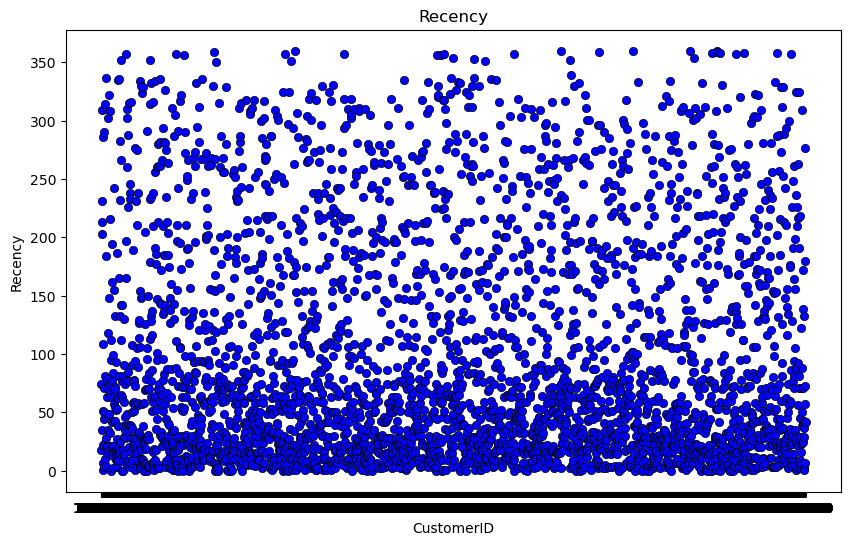

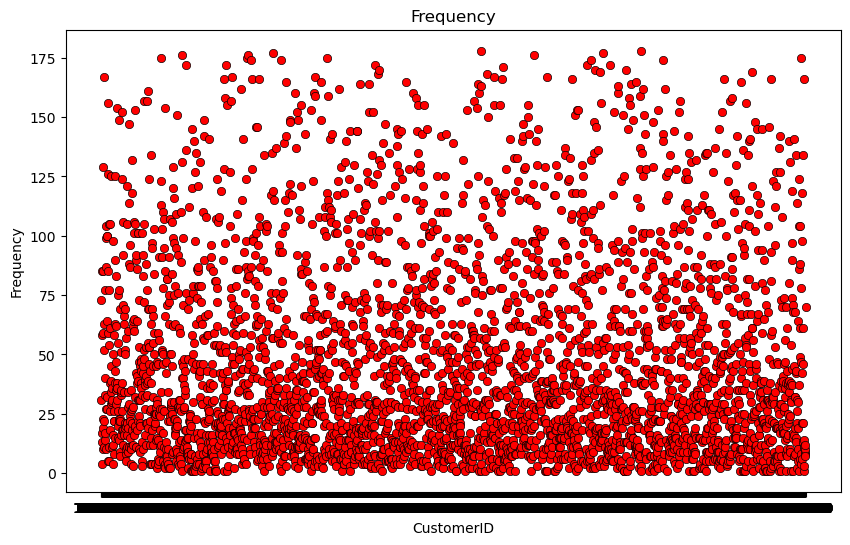

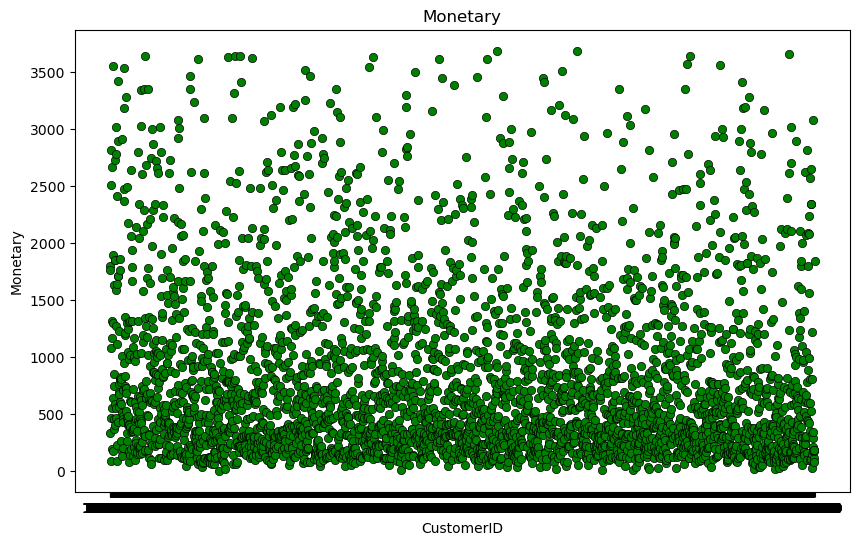

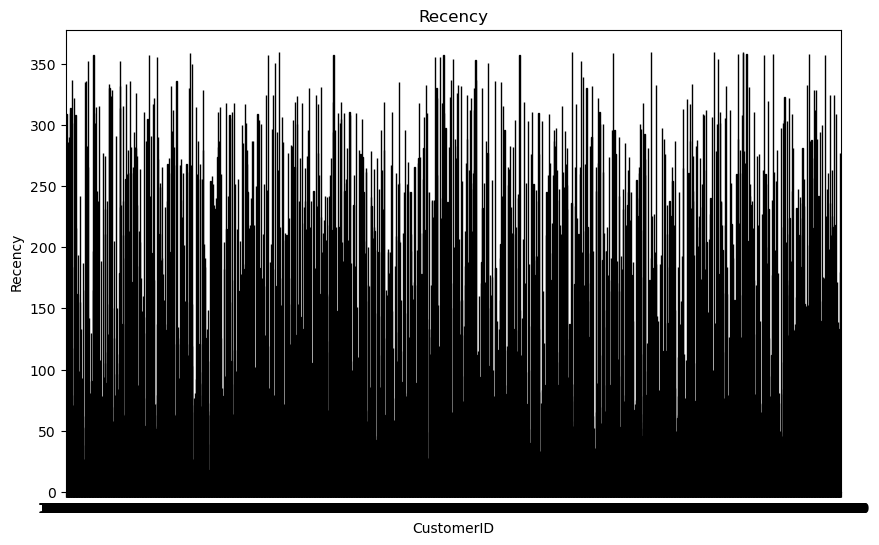

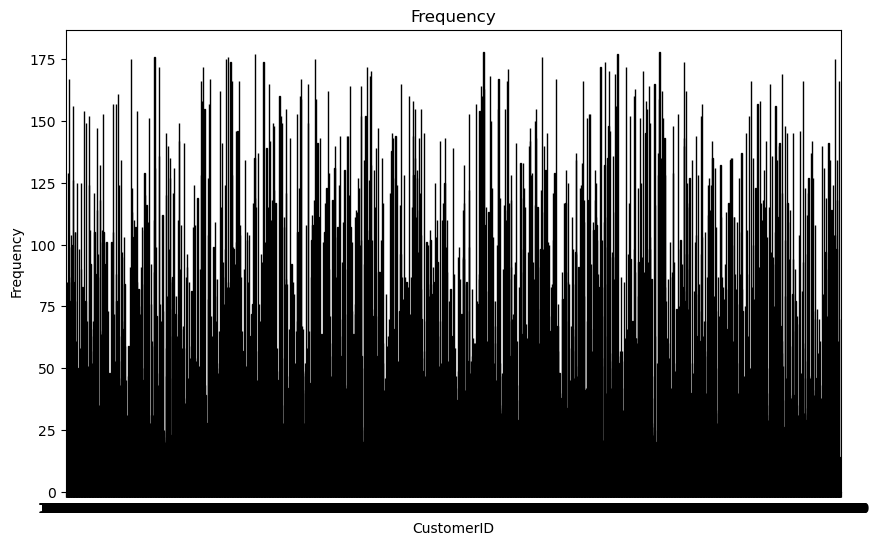

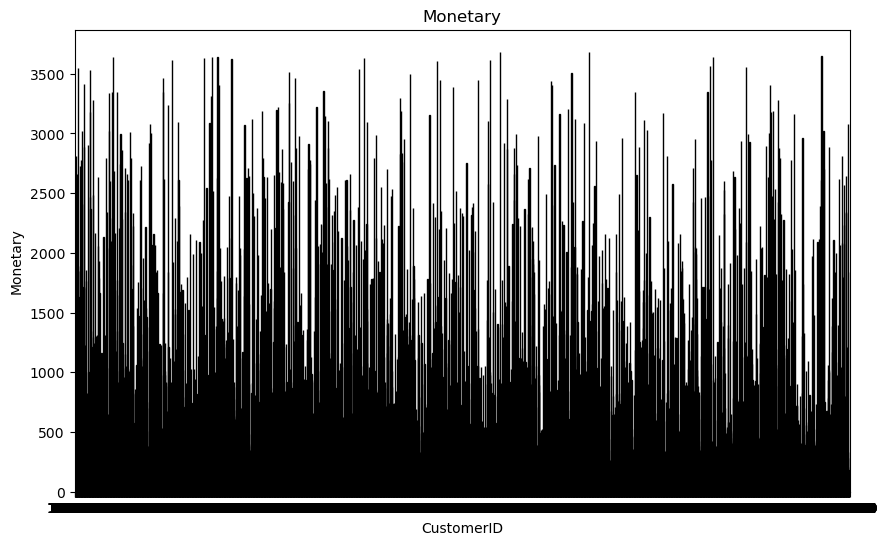

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm_df, x='CustomerID', y='Recency', color='blue', edgecolor='k')
plt.title('Recency')
plt.xlabel('CustomerID')
plt.ylabel('Recency')
plt.show()


plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm_df, x='CustomerID', y='Frequency', color='red', edgecolor='k')
plt.title('Frequency')
plt.xlabel('CustomerID')
plt.ylabel('Frequency')
plt.show()


plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm_df, x='CustomerID', y='Amount', color='green', edgecolor='k')
plt.title('Monetary')
plt.xlabel('CustomerID')
plt.ylabel('Monetary')
plt.show()


plt.figure(figsize=(10, 6))
sns.barplot(data=rfm_df, x='CustomerID', y='Recency', color='blue', edgecolor='k')
plt.title('Recency')
plt.xlabel('CustomerID')
plt.ylabel('Recency')
plt.show()


plt.figure(figsize=(10, 6))
sns.barplot(data=rfm_df, x='CustomerID', y='Frequency', color='red', edgecolor='k')
plt.title('Frequency')
plt.xlabel('CustomerID')
plt.ylabel('Frequency')
plt.show()


plt.figure(figsize=(10, 6))
sns.barplot(data=rfm_df, x='CustomerID', y='Amount', color='green', edgecolor='k')
plt.title('Monetary')
plt.xlabel('CustomerID')
plt.ylabel('Monetary')
plt.show()


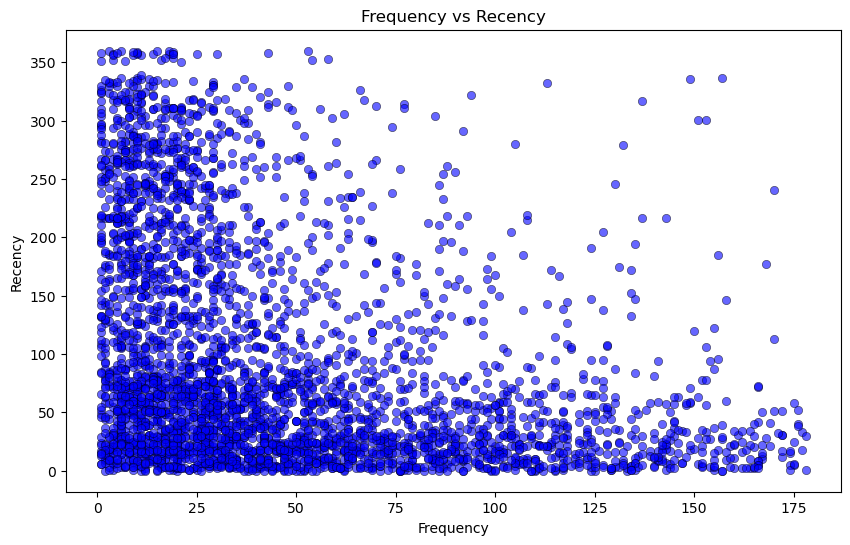

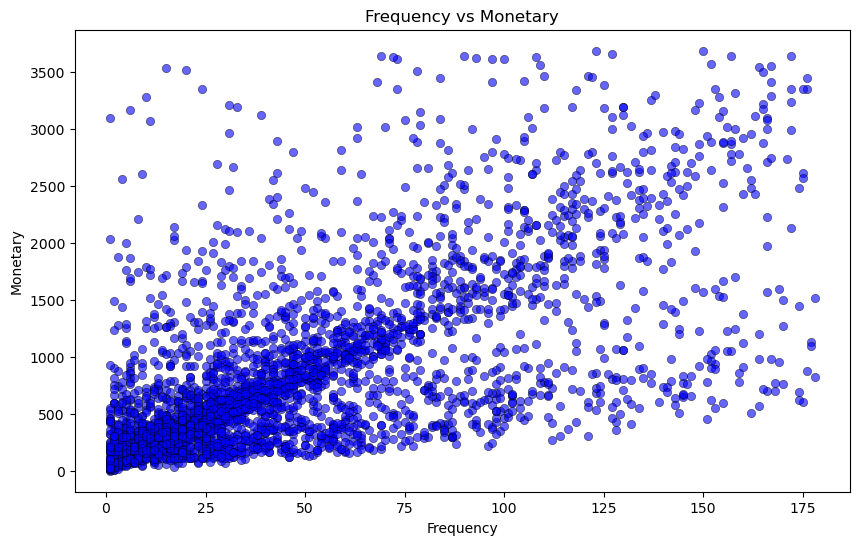

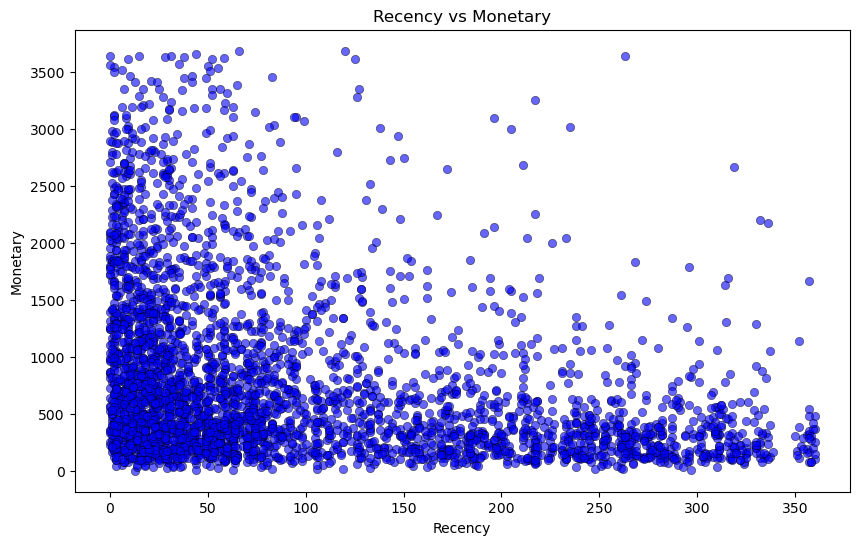

In [35]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm_df, x='Frequency', y='Recency', sizes=(50, 500), alpha=0.6, edgecolor='k', color='blue')


plt.title('Frequency vs Recency')
plt.xlabel('Frequency')
plt.ylabel('Recency')



plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm_df, x='Frequency', y='Amount', sizes=(50, 500), alpha=0.6, edgecolor='k', color='blue')


plt.title('Frequency vs Monetary')
plt.xlabel('Frequency')
plt.ylabel('Monetary')


plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm_df, x='Recency', y='Amount', sizes=(50, 500), alpha=0.6, edgecolor='k', color='blue')

plt.title('Recency vs Monetary')
plt.xlabel('Recency')
plt.ylabel('Monetary')

plt.show()

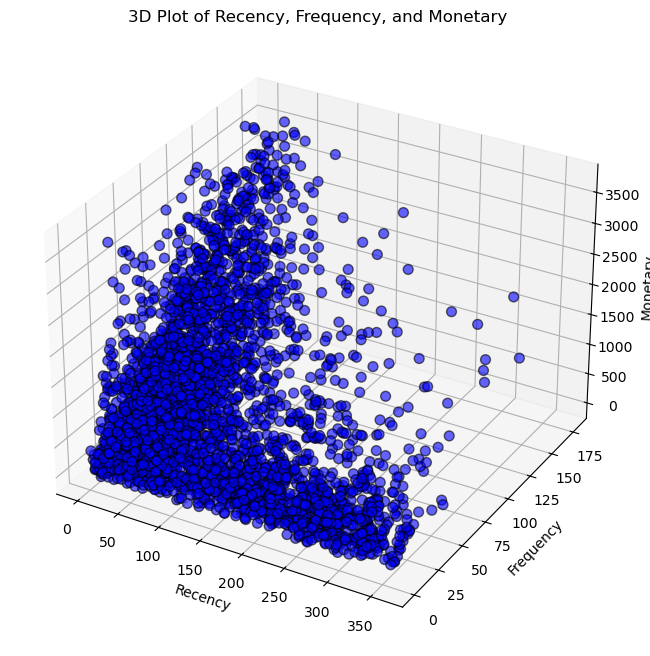

In [36]:
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns


fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')  


scatter = ax.scatter(rfm_df['Recency'], rfm_df['Frequency'], rfm_df['Amount'], 
                     c='blue', alpha=0.6, edgecolor='k', s=50)


ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')


ax.set_title('3D Plot of Recency, Frequency, and Monetary')


plt.show()

# Modelling

In [37]:
#model creation
kmeans = KMeans(n_clusters= 3,max_iter= 50)
kmeans.fit(rfm_ds_scaled)
lbs = kmeans.labels_
print(kmeans.labels_)

[2 0 1 ... 1 2 0]


In [38]:
#model creation
kmeans = KMeans(n_clusters= 3,max_iter= 50)
kmeans.fit(rfm_ds_scaled)
lbs = kmeans.labels_
print(kmeans.labels_)

[1 0 2 ... 2 1 0]


In [39]:
#silhouette score
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters= num_clusters, max_iter= 50)
    kmeans.fit(rfm_ds_scaled)
    cluster_labels = kmeans.labels_
    silhouette_avg = silhouette_score(rfm_ds_scaled, cluster_labels)
    print('For n_clusters{0}, the silhouette score is {1}'.format(num_clusters, silhouette_avg))

For n_clusters2, the silhouette score is 0.3932759448323845
For n_clusters3, the silhouette score is 0.45909556257124096
For n_clusters4, the silhouette score is 0.41185754463529944
For n_clusters5, the silhouette score is 0.3584577816051503
For n_clusters6, the silhouette score is 0.36285282254993245
For n_clusters7, the silhouette score is 0.3664758185539979
For n_clusters8, the silhouette score is 0.3420610785469612


In [40]:
X = rfm_ds_final
X.head()

,CustomerID,Amount,Frequency,Recency
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309
5,12352.0,2506.04,85,35
6,12353.0,89.00,4,203


In [41]:
# final_model labels
final_model = make_pipeline(
    StandardScaler(),
    KMeans(n_clusters=3, random_state=42)
)
# Predict class labels
labels = final_model.fit_predict(X)
print(labels[:10])

[2 1 0 1 0 0 0 1 2 1]


In [42]:
X['labels'] = final_model.named_steps["kmeans"].labels_
print(labels[:10])

[2 1 0 1 0 0 0 1 2 1]


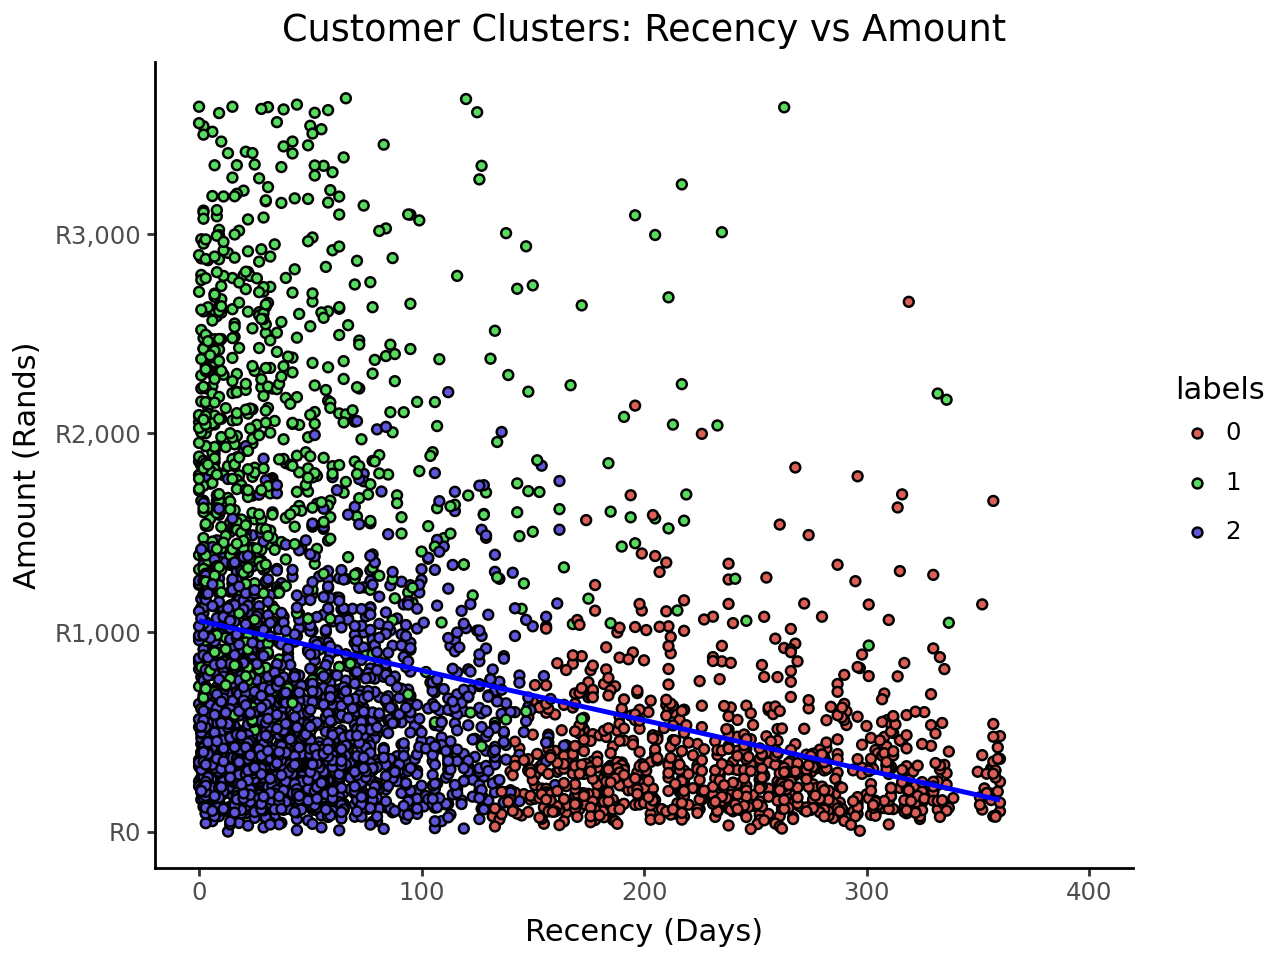

In [43]:
import plotnine as pn
from plotnine import *

# Create a plot area
p = (
    ggplot(X, aes(x='Recency', y='Amount')) +
    # Add points into the plot area
    geom_point(aes(fill=X['labels'].astype(str))) +
    # Add a blue smooth line
    geom_smooth(color="blue", se=False) +
    # Format x-axis scale to display 'Frequency'
    scale_x_continuous(
        name='Recency (Days)',
        labels=lambda x: [f'{x:,.0f}' for x in x],
        limits=(0, 400)  # Adjust x-axis limits to zoom in
    ) +
    # Format y-axis scale to display 'Rands'
    scale_y_continuous(
        name='Amount (Rands)',
        labels=lambda y: [f'R{y:,.0f}' for y in y]
    ) +
    # Add title to the plot
    labs(title="Customer Clusters: Recency vs Amount") +
    # Add plot theme
    theme_classic()
)

# Show the plot
print(p)


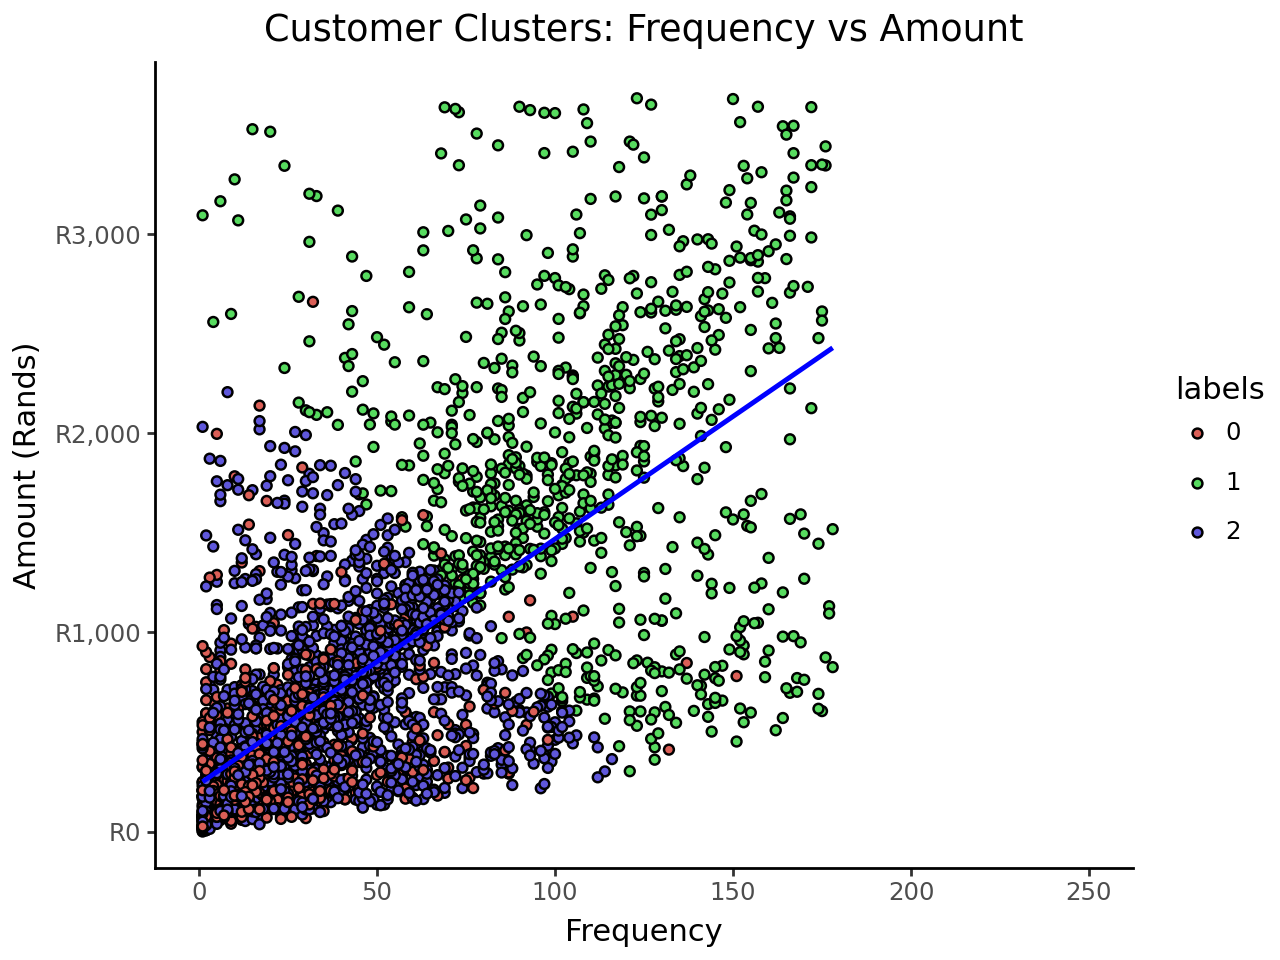

In [44]:
import plotnine as pn
from plotnine import *

# Create a plot area
p = (
    ggplot(X, aes(x='Frequency', y='Amount')) +
    # Add points into the plot area
    geom_point(aes(fill=X['labels'].astype(str))) +
    # Add a blue smooth line
    geom_smooth(color="blue", se=False) +
    # Format x-axis scale to display 'Frequency'
    scale_x_continuous(
        name='Frequency',
        labels=lambda x: [f'{x:,.0f}' for x in x],
        limits=(0, 250)  # Adjust x-axis limits to zoom in
    ) +
    # Format y-axis scale to display 'Rands'
    scale_y_continuous(
        name='Amount (Rands)',
        labels=lambda y: [f'R{y:,.0f}' for y in y]
    ) +
    # Add title to the plot
    labs(title="Customer Clusters: Frequency vs Amount") +
    # Add plot theme
    theme_classic()
)

# Show the plot
print(p)

# Web Application

# Future Work And Reflection

# Conclusion

The customers were succesfully segmented into 3 clusters that represents different value customers according to a recency frequecy monetary analysis. The best customers being the highest and most recent, frequent spenders were assigned to cluster 0 and is considered most valuable and the business can offer them rewards for their lotyalty. Cluster 2 could be considered average value customers and cluster 3 represents the customers the business should market more aggresively towards and offer incentitives to spend more money, more frequently.